# Global overview tables and statistics

This is a bit messy, but there is a bunch of code producing maps and stats for the technical report.

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import sys, os
import os
import matplotlib.patches as mpatches
from oggm import utils
import csv
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
from matplotlib.image import imread

In [2]:
# go down from rgi7_scripts/workflow
data_dir = '../../../../rgi7_data/'

final_dir = os.path.join(data_dir, 'rgi7_final')

In [3]:
user_guide_dir = '../../../../rgi_user_guide/'

In [4]:
overlap_dir = os.path.join(data_dir, 'rgi7_rgi6_links')

## Read RGI6 and RGI7 attrs 

In [5]:
df_rgi7g = pd.read_csv(os.path.join(final_dir, 'global_files', 'attributes', 'RGI2000-v7.0-G-global-attributes.csv.zip'), 
                       index_col=0,
                       compression='zip',
                       dtype={'o1region': str})

In [6]:
df_rgi6g = pd.read_hdf(utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5'))
df_rgi6g = df_rgi6g.loc[df_rgi6g.Connect != 2]

In [7]:
df_rgi7c = pd.read_csv(os.path.join(final_dir, 'global_files', 'attributes', 'RGI2000-v7.0-C-global-attributes.csv.zip'), 
                       index_col=0,
                       compression='zip',
                       dtype={'o1region': str})

In [8]:
np.testing.assert_allclose(df_rgi7g.area_km2.sum(), df_rgi7c.area_km2.sum())

In [9]:
df_reg_o1 = gpd.read_file('zip://' + final_dir + '/RGI2000-v7.0-regions.zip/RGI2000-v7.0-o1regions.shp')
df_reg_o2 = gpd.read_file('zip://' + final_dir + '/RGI2000-v7.0-regions.zip/RGI2000-v7.0-o2regions.shp')

## RGI6 vs RGI7 table for `overview.md`

In [10]:
df = df_rgi6g.groupby('O1Region')[['Area']].sum()
df.columns = ['Area RGI6']

In [11]:
df['Area RGI7'] = df_rgi7g.groupby('o1region')[['area_km2']].sum()

In [12]:
df['Diff A (%)'] = (df['Area RGI7'] / df['Area RGI6'] - 1) * 100

In [13]:
df['N RGI6'] = df_rgi6g.groupby('O1Region').count()['Area']
df['N RGI7'] = df_rgi7g.groupby('o1region').count()['area_km2']

df['Diff N (%)'] = (df['N RGI7'] / df['N RGI6'] - 1) * 100

In [14]:
df.loc['20'] = [0] * 6

In [15]:
ss = df.sum()
ss.name = 'Global'
df = pd.concat([df, ss.to_frame().T])

df['Diff A (%)'] = (df['Area RGI7'] / df['Area RGI6'] - 1) * 100
df['Diff N (%)'] = (df['N RGI7'] / df['N RGI6'] - 1) * 100

In [16]:
df['Area RGI6'] = df['Area RGI6'].astype(float).round(0).astype(int) 
df['Area RGI7'] = df['Area RGI7'].astype(float).round(0).astype(int) 
df['N RGI6'] = df['N RGI6'].astype(int) 
df['N RGI7'] = df['N RGI7'].astype(int) 

df['Diff A (%)'] = df['Diff A (%)'].round(1).replace(-0, 0).replace(np.NaN, 0)
df['Diff N (%)'] = df['Diff N (%)'].round(1).replace(-0, 0).replace(np.NaN, 0)

In [17]:
df

Area RGI6  Area RGI7  Diff A (%)  N RGI6  N RGI7  Diff N (%)
01          86725      86708         0.0   27108   27509         1.5
02          14524      14521         0.0   18855   18730        -0.7
03         105111     105370         0.2    4556    5216        14.5
04          40888      40538        -0.9    7415   11009        48.5
05          89717      90482         0.9   19306   19994         3.6
06          11060      11060         0.0     568     568         0.0
07          33959      33959         0.0    1615    1666         3.2
08           2949       2948         0.0    3417    3410        -0.2
09          51592      51595         0.0    1069    1069         0.0
10           2410       2643         9.6    5151    7155        38.9
11           2092       2124         1.5    3927    4079         3.9
12           1307       1407         7.6    1888    2275        20.5
13          49303      50344         2.1   54429   75613        38.9
14          33568      33075        -1.5   27988   37562        34.2
15          14734      16049         8.9   13119   18587        41.7
16           2341       1929       -17.6    2939    3695        25.7
17          29429      27674        -6.0   15908   30634        92.6
18           1162        886       -23.7    3537    3018       -14.7
19         132867     133432         0.4    2752    2742        -0.4
20              0          0         0.0       0       0         0.0
Global     705739     706744         0.1  215547  274531        27.4

In [18]:
print(f"N in RGI7: N={len(df_rgi7g)}, A={int(df_rgi7g['area_km2'].sum())} km²")

s1 = df_rgi7g.loc[df_rgi7g.is_rgi6 == 1]
print(f"Same as RGI6: N={len(s1)}, A={int(s1['area_km2'].sum())} km²")

s2 = df_rgi7g.loc[df_rgi7g.is_rgi6 == 0]
print(f"New  in RGI7: N={len(s2)}, A={int(s2['area_km2'].sum())} km²")

print(f"New in % area: {s2['area_km2'].sum() / df_rgi7g['area_km2'].sum()}")

print(f"New in % number: {len(s2) / len(df_rgi7g)}")

N in RGI7: N=274531, A=706744 km²
Same as RGI6: N=73797, A=410788 km²
New  in RGI7: N=200734, A=295955 km²
New in % area: 0.41875848090612894
New in % number: 0.7311888274912487


In [19]:
df.index.name = 'Region'

In [20]:
df_formd = df.copy()
df_formd.index = [f'[](rgi{i}.md)' for i in df_formd.index[:-1]] + ['Global']
df_formd.columns = ['Area<br>RGI 6.0 (km²)', 'Area<br>RGI 7.0 (km²)', 'Area<br>Diff. (%)', 'Count<br>RGI 6.0', 'Count<br>RGI 7.0', 'Count<br>Diff. (%)']
print(df_formd.to_markdown(floatfmt=(".0f",".0f",".0f",".1f",".0f",".0f",".1f")).replace('Global    ', '**Global**'))

|              |   Area<br>RGI 6.0 (km²) |   Area<br>RGI 7.0 (km²) |   Area<br>Diff. (%) |   Count<br>RGI 6.0 |   Count<br>RGI 7.0 |   Count<br>Diff. (%) |
|:-------------|------------------------:|------------------------:|--------------------:|-------------------:|-------------------:|---------------------:|
| [](rgi01.md) |                   86725 |                   86708 |                 0.0 |              27108 |              27509 |                  1.5 |
| [](rgi02.md) |                   14524 |                   14521 |                 0.0 |              18855 |              18730 |                 -0.7 |
| [](rgi03.md) |                  105111 |                  105370 |                 0.2 |               4556 |               5216 |                 14.5 |
| [](rgi04.md) |                   40888 |                   40538 |                -0.9 |               7415 |              11009 |                 48.5 |
| [](rgi05.md) |                   89717 |                   904

In [21]:
df['Full name'] = list(df_reg_o1.full_name.unique()) + ['']
df['Code'] = ['`' + r + '`' for r in df_reg_o1.long_code.unique()] + ['']

In [22]:
df

Area RGI6  Area RGI7  Diff A (%)  N RGI6  N RGI7  Diff N (%)  \
Region                                                                 
01          86725      86708         0.0   27108   27509         1.5   
02          14524      14521         0.0   18855   18730        -0.7   
03         105111     105370         0.2    4556    5216        14.5   
04          40888      40538        -0.9    7415   11009        48.5   
05          89717      90482         0.9   19306   19994         3.6   
06          11060      11060         0.0     568     568         0.0   
07          33959      33959         0.0    1615    1666         3.2   
08           2949       2948         0.0    3417    3410        -0.2   
09          51592      51595         0.0    1069    1069         0.0   
10           2410       2643         9.6    5151    7155        38.9   
11           2092       2124         1.5    3927    4079         3.9   
12           1307       1407         7.6    1888    2275        20.5   
13          49303      50344         2.1   54429   75613        38.9   
14          33568      33075        -1.5   27988   37562        34.2   
15          14734      16049         8.9   13119   18587        41.7   
16           2341       1929       -17.6    2939    3695        25.7   
17          29429      27674        -6.0   15908   30634        92.6   
18           1162        886       -23.7    3537    3018       -14.7   
19         132867     133432         0.4    2752    2742        -0.4   
20              0          0         0.0       0       0         0.0   
Global     705739     706744         0.1  215547  274531        27.4   

                                 Full name  \
Region                                       
01                                  Alaska   
02                  Western Canada and USA   
03                     Arctic Canada North   
04                     Arctic Canada South   
05                     Greenland Periphery   
06                                 Iceland   
07                  Svalbard and Jan Mayen   
08                             Scandinavia   
09                          Russian Arctic   
10                              North Asia   
11                          Central Europe   
12                Caucasus and Middle East   
13                            Central Asia   
14                         South Asia West   
15                         South Asia East   
16                           Low Latitudes   
17                          Southern Andes   
18                             New Zealand   
19      Subantarctic and Antarctic Islands   
20                      Antarctic Mainland   
Global                                       

                                       Code  
Region                                       
01                              `01_alaska`  
02                  `02_western_canada_usa`  
03                 `03_arctic_canada_north`  
04                 `04_arctic_canada_south`  
05                 `05_greenland_periphery`  
06                             `06_iceland`  
07                  `07_svalbard_jan_mayen`  
08                         `08_scandinavia`  
09                      `09_russian_arctic`  
10                          `10_north_asia`  
11                      `11_central_europe`  
12                `12_caucasus_middle_east`  
13                        `13_central_asia`  
14                     `14_south_asia_west`  
15                     `15_south_asia_east`  
16                       `16_low_latitudes`  
17                      `17_southern_andes`  
18                         `18_new_zealand`  
19      `19_subantarctic_antarctic_islands`  
20                  `20_antarctic_mainland`  
Global

In [23]:
for_csv = df[['Full name', 'Area RGI6', 'Area RGI7', 'Diff A (%)', 'N RGI6', 'N RGI7', 'Diff N (%)']].copy()
for_csv.columns = ['Full name', 'Area RGI 6.0', 'Area RGI 7.0', 'Diff. Area (%)', 'Count RGI 6.0', 'Count RGI 7.0', 'Diff. Count (%)']
for_csv.reset_index().to_csv(user_guide_dir + '/docs/appendix/RGI2000-v7.0-G-comparison-rgi6.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

## Add overlap info 

In [60]:
dfoverlap = pd.read_csv(os.path.join(overlap_dir, 'RGI2000-v7.0-G-global-rgi6_links.csv'))

In [61]:
dfover = df.copy()
dfover['Area overlap'] = 0

In [62]:
dfover.loc[:'19', 'Area overlap'] = dfoverlap.groupby('rgi7_reg')['overlap_area_km2'].sum().values
dfover.loc['Global', 'Area overlap'] = dfoverlap['overlap_area_km2'].sum()

In [63]:
dfover['Area removed from RGI6'] = dfover['Area RGI6'] - dfover['Area overlap']
dfover['Area removed from RGI6 (%)'] = dfover['Area removed from RGI6'] / dfover['Area RGI6'] * 100
dfover['Area added in RGI7'] = dfover['Area RGI7'] - dfover['Area overlap']
dfover['Area added in RGI7 (%)'] = dfover['Area added in RGI7'] / dfover['Area RGI7'] * 100

In [64]:
for c in ['Area removed from RGI6 (%)', 'Area added in RGI7 (%)']:
    dfover[c] = dfover[c].round(1).replace(-0, 0).replace(np.NaN, 0)
for c in ['Area removed from RGI6', 'Area added in RGI7', 'Area overlap']:
    dfover[c] = dfover[c].astype(float).round(0).astype(int)

In [65]:
for_csv = dfover[dfover.columns[[6, 0, 1, 2, 8, 9, 11, 10, 12]]].copy()
for_csv.columns = ['Full name', 'Area RGI 6.0', 'Area RGI 7.0', 'Diff. Area (%)',
       'Area overlap', 'Area removed from RGI6', 'Area added in RGI7',
       'Area removed from RGI 6.0 (%)', 'Area added in RGI 7.0 (%)'] 
for_csv.reset_index().to_csv(user_guide_dir + '/docs/appendix/RGI2000-v7.0-G-comparison-rgi6-area.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [74]:
df_formd = dfover[dfover.columns[[0, 1, 2, 8, 9, 11, 10, 12]]].copy()
df_formd.index = [f'[](rgi{i}.md)' for i in df_formd.index[:-1]] + ['Global']
df_formd.columns = ['Area<br>RGI 6.0 (km²)', 'Area<br>RGI 7.0 (km²)', 'Area<br>Diff. (%)', 'Area overlap (km²)', 
                    'Area removed from RGI 6.0 (km²)', 'Area added in RGI 7.0 (km²)',
                    'Area removed from RGI 6.0 (%)', 'Area added in RGI 7.0 (%)']
print(df_formd.to_markdown(floatfmt=(".0f",".0f",".0f",".1f",".0f",".0f",".0f",".1f",".1f")).replace('Global    ', '**Global**'))

|              |   Area<br>RGI 6.0 (km²) |   Area<br>RGI 7.0 (km²) |   Area<br>Diff. (%) |   Area overlap (km²) |   Area removed from RGI 6.0 (km²) |   Area added in RGI 7.0 (km²) |   Area removed from RGI 6.0 (%) |   Area added in RGI 7.0 (%) |
|:-------------|------------------------:|------------------------:|--------------------:|---------------------:|----------------------------------:|------------------------------:|--------------------------------:|----------------------------:|
| [](rgi01.md) |                   86725 |                   86708 |                 0.0 |                86627 |                                98 |                            81 |                             0.1 |                         0.1 |
| [](rgi02.md) |                   14524 |                   14521 |                 0.0 |                14521 |                                 3 |                             0 |                             0.0 |                         0.0 |
| [](rgi03.md) |

## Tables Appendix (no RGI6) 

### O1 

In [23]:
for_csv = df[['Full name', 'Code', 'N RGI7', 'Area RGI7']].copy()
for_csv['Code'] = [s.replace("`", "") for s in for_csv['Code']]

In [24]:
for_csv.columns = [['full_name', 'long_code', 'count', 'area_km2']]
for_csv.index.name = 'o1region'
for_csv.reset_index().to_csv(user_guide_dir + '/docs/appendix/RGI2000-v7.0-G-o1region-summary.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [25]:
for_print = df[['Full name', 'Code', 'N RGI7', 'Area RGI7']]
for_print.columns = ['Full name', 'Code', 'Count', 'Area (km²)']
print(for_print.to_markdown().replace('Global    ', '**Global**'))

| Region   | Full name                          | Code                                |   Count |   Area (km²) |
|:---------|:-----------------------------------|:------------------------------------|--------:|-------------:|
| 01       | Alaska                             | `01_alaska`                         |   27509 |        86708 |
| 02       | Western Canada and USA             | `02_western_canada_usa`             |   18730 |        14521 |
| 03       | Arctic Canada North                | `03_arctic_canada_north`            |    5216 |       105370 |
| 04       | Arctic Canada South                | `04_arctic_canada_south`            |   11009 |        40538 |
| 05       | Greenland Periphery                | `05_greenland_periphery`            |   19994 |        90482 |
| 06       | Iceland                            | `06_iceland`                        |     568 |        11060 |
| 07       | Svalbard and Jan Mayen             | `07_svalbard_jan_mayen`             |    1666 

### O2 

In [26]:
df_reg_o2 = df_reg_o2.drop_duplicates('o2region')
df_reg_o2

o1region o2region                           full_name  \
0        01    01-01                        North Alaska   
1        01    01-02     Alaska Range (Wrangell/Kilbuck)   
2        01    01-03        Alaska Peninsula (Aleutians)   
3        01    01-04  West Chugach Mountains (Talkeetna)   
4        01    01-05               Saint Elias Mountains   
..      ...      ...                                 ...   
86       19    19-21   Northeast Antarctic Peninsula 7I2   
87       19    19-22   Southeast Antarctic Peninsula 7I3   
88       19    19-23         Ronne-Filchner Ice Shelf 7J   
89       19    19-24             West Queen Maud Land 7K   
90       20    20-01                  Antarctic Mainland   

                                  long_code  \
0                        01-01_north_alaska   
1       01-02_alaska_range_wrangell_kilbuck   
2          01-03_alaska_peninsula_aleutians   
3    01-04_west_chugach_mountains_talkeetna   
4               01-05_saint_elias_mountains   
..                                      ...   
86  19-21_northeast_antarctic_peninsula_7i2   
87  19-22_southeast_antarctic_peninsula_7i3   
88        19-23_ronne_filchner_ice_shelf_7j   
89            19-24_west_queen_maud_land_7k   
90                 20-01_antarctic_mainland   

                                             geometry  
0   POLYGON ((-169.00000 64.00000, -169.00000 65.0...  
1   POLYGON ((-144.40436 61.48531, -144.48100 61.5...  
2   POLYGON ((-180.00000 57.00000, -179.00000 57.0...  
3   POLYGON ((-151.32973 58.74602, -151.57953 58.8...  
4   POLYGON ((-144.25108 61.44018, -144.07510 61.3...  
..                                                ...  
86  POLYGON ((-62.41123 -69.50624, -62.41913 -69.5...  
87  POLYGON ((-50.00000 -74.80000, -51.00000 -74.8...  
88  POLYGON ((-42.00000 -74.80000, -41.00000 -74.8...  
89  POLYGON ((-10.30000 -69.40000, -10.00000 -69.4...  
90  POLYGON ((131.99251 -66.18084, 132.10675 -66.1...  

[90 rows x 5 columns]

In [27]:
dfsr = df_reg_o2[['o2region', 'full_name', 'long_code']].copy().set_index('o2region')

dfsr.columns = ['Full name', 'Code']

dfsr['Count'] = df_rgi7g.groupby('o2region')['cenlon'].count()
dfsr['Area (km²)'] = df_rgi7g.groupby('o2region')['area_km2'].sum()

ss = dfsr.sum()
ss.name = 'Global'
dfsr = pd.concat([dfsr, ss.to_frame().T])

dfsr.loc['Global', 'Full name'] = ''
dfsr.loc['Global', 'Code'] = ''

dfsr['Area (km²)']  = dfsr['Area (km²)'].astype(float).round(0).fillna(0).astype(int) 
dfsr['Count']  = dfsr['Count'].fillna(0).astype(int) 

dfsr['Code'] = ['`' + r + '`' for r in dfsr.Code]
dfsr.loc['Global', 'Code'] = ''

In [28]:
print(dfsr.to_markdown())

|        | Full name                                | Code                                           |   Count |   Area (km²) |
|:-------|:-----------------------------------------|:-----------------------------------------------|--------:|-------------:|
| 01-01  | North Alaska                             | `01-01_north_alaska`                           |     706 |          364 |
| 01-02  | Alaska Range (Wrangell/Kilbuck)          | `01-02_alaska_range_wrangell_kilbuck`          |    5812 |        16284 |
| 01-03  | Alaska Peninsula (Aleutians)             | `01-03_alaska_peninsula_aleutians`             |     872 |         1912 |
| 01-04  | West Chugach Mountains (Talkeetna)       | `01-04_west_chugach_mountains_talkeetna`       |    4529 |        12005 |
| 01-05  | Saint Elias Mountains                    | `01-05_saint_elias_mountains`                  |    5039 |        33178 |
| 01-06  | North Coast Ranges                       | `01-06_north_coast_ranges`                     |  

In [29]:
dfsr['Code'] = [s.replace("`", "") for s in dfsr['Code']]
dfsr.columns = [['full_name', 'long_code', 'count', 'area_km2']]
dfsr.index.name = 'o2region'
dfsr.reset_index().to_csv(user_guide_dir + '/docs/appendix/RGI2000-v7.0-G-o2region-summary.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

## Global statistics (`06_dataset_summary.md`) 

In [30]:
rgi6 = df_rgi6g.copy()
rgi7 = df_rgi7g.copy()

### Target year 

In [31]:
rgi7['year'] = [int(y.split('-')[0]) for y in rgi7['src_date']]
rgi6['year'] = [int(y[0:4]) for y in rgi6['BgnDate']]

In [32]:
dy6 = np.abs(rgi6['year'] - 2000)
dy7 = np.abs(rgi7['year'] - 2000)

In [33]:
ydf = pd.DataFrame()
ydf.loc['2000 ± 2 years', 'RGI6 (%)'] = (dy6 <= 2).sum() / len(rgi6) * 100
ydf.loc['2000 ± 2 years', 'RGI7 (%)'] = (dy7 <= 2).sum() / len(rgi7) * 100
ydf.loc['2000 ± 2-5 years', 'RGI6 (%)'] = ((dy6 <= 5) & (dy6 > 2)).sum() / len(rgi6) * 100
ydf.loc['2000 ± 2-5 years', 'RGI7 (%)'] = ((dy7 <= 5) & (dy7 > 2)).sum() / len(rgi7) * 100
ydf.loc['2000 ± 5-10 years', 'RGI6 (%)'] = ((dy6 <= 10) & (dy6 > 5)).sum() / len(rgi6) * 100
ydf.loc['2000 ± 5-10 years', 'RGI7 (%)'] = ((dy7 <= 10) & (dy7 > 5)).sum() / len(rgi7) * 100
ydf.loc['2000 ± > 10 years', 'RGI6 (%)'] = (dy6 > 10).sum() / len(rgi6) * 100
ydf.loc['2000 ± > 10 years', 'RGI7 (%)'] = (dy7 > 10).sum() / len(rgi7) * 100
ydf = ydf.round(1)
ydf.index.name = 'Outline year'
ydf.columns = ['RGI 6.0 (%)', 'RGI 7.0 (%)']
ydf

RGI 6.0 (%)  RGI 7.0 (%)
Outline year                               
2000 ± 2 years            48.9         58.0
2000 ± 2-5 years          15.9         18.7
2000 ± 5-10 years         27.0         19.5
2000 ± > 10 years          8.2          3.8

In [34]:
print(ydf.to_markdown())

| Outline year      |   RGI 6.0 (%) |   RGI 7.0 (%) |
|:------------------|--------------:|--------------:|
| 2000 ± 2 years    |          48.9 |          58   |
| 2000 ± 2-5 years  |          15.9 |          18.7 |
| 2000 ± 5-10 years |          27   |          19.5 |
| 2000 ± > 10 years |           8.2 |           3.8 |


Same but with area (less good):

In [35]:
ydf = pd.DataFrame()
ydf.loc['2000 ± 2 years', 'RGI6 (%)'] = rgi6.loc[(dy6 <= 2)].Area.sum() / rgi6.Area.sum() * 100
ydf.loc['2000 ± 2 years', 'RGI7 (%)'] = rgi7.loc[(dy7 <= 2)].area_km2.sum() / rgi7.area_km2.sum() * 100
ydf.loc['2000 ± 2-5 years', 'RGI6 (%)'] = rgi6.loc[((dy6 <= 5) & (dy6 > 2))].Area.sum() / rgi6.Area.sum() * 100
ydf.loc['2000 ± 2-5 years', 'RGI7 (%)'] = rgi7.loc[((dy7 <= 5) & (dy7 > 2))].area_km2.sum() / rgi7.area_km2.sum() * 100
ydf.loc['2000 ± 5-10 years', 'RGI6 (%)'] = rgi6.loc[((dy6 <= 10) & (dy6 > 5))].Area.sum() / rgi6.Area.sum() * 100
ydf.loc['2000 ± 5-10 years', 'RGI7 (%)'] = rgi7.loc[((dy7 <= 10) & (dy7 > 5))].area_km2.sum() / rgi7.area_km2.sum() * 100
ydf.loc['2000 ± > 10 years', 'RGI6 (%)'] = rgi6.loc[(dy6 > 10)].Area.sum() / rgi6.Area.sum() * 100
ydf.loc['2000 ± > 10 years', 'RGI7 (%)'] = rgi7.loc[(dy7 > 10)].area_km2.sum() / rgi7.area_km2.sum() * 100
ydf = ydf.round(1)
ydf.index.name = 'Outline year'
ydf.columns = ['RGI 6.0 (%)', 'RGI 7.0 (%)']
ydf

RGI 6.0 (%)  RGI 7.0 (%)
Outline year                               
2000 ± 2 years            54.4         55.8
2000 ± 2-5 years          11.4         15.4
2000 ± 5-10 years         20.9         20.0
2000 ± > 10 years         13.3          8.8

### More year statistics 

In [38]:
rgi7['year'].min(), rgi7['year'].max()

(1943, 2021)

In [40]:
(rgi7['year'] < 1990).sum() / len(rgi7)

0.028608790992638355

### Size classes 

In [74]:
adf = pd.DataFrame()
adf.loc['< 1 km²', 'RGI6 (N)'] = (rgi6['Area'] < 1).sum()
adf.loc['< 1 km²', 'RGI6 (%)'] = (rgi6['Area'] < 1).sum() / len(rgi6) * 100
adf.loc['< 1 km²', 'RGI7 (N)'] = (rgi7['area_km2'] < 1).sum()
adf.loc['< 1 km²', 'RGI7 (%)'] = (rgi7['area_km2'] < 1).sum() / len(rgi7) * 100
adf.loc['1-10 km²', 'RGI6 (N)'] = ((rgi6['Area'] >= 1) & (rgi6['Area'] < 10)).sum()
adf.loc['1-10 km²', 'RGI6 (%)'] = ((rgi6['Area'] >= 1) & (rgi6['Area'] < 10)).sum() / len(rgi6) * 100
adf.loc['1-10 km²', 'RGI7 (N)'] = ((rgi7['area_km2'] >= 1) & (rgi7['area_km2'] < 10)).sum()
adf.loc['1-10 km²', 'RGI7 (%)'] = ((rgi7['area_km2'] >= 1) & (rgi7['area_km2'] < 10)).sum() / len(rgi7) * 100
adf.loc['10-100 km²', 'RGI6 (N)'] = ((rgi6['Area'] >= 10) & (rgi6['Area'] < 100)).sum()
adf.loc['10-100 km²', 'RGI6 (%)'] = ((rgi6['Area'] >= 10) & (rgi6['Area'] < 100)).sum() / len(rgi6) * 100
adf.loc['10-100 km²', 'RGI7 (N)'] = ((rgi7['area_km2'] >= 10) & (rgi7['area_km2'] < 100)).sum()
adf.loc['10-100 km²', 'RGI7 (%)'] = ((rgi7['area_km2'] >= 10) & (rgi7['area_km2'] < 100)).sum() / len(rgi7) * 100
adf.loc['> 100 km²', 'RGI6 (N)'] = (rgi6['Area'] >= 100).sum()
adf.loc['> 100 km²', 'RGI6 (%)'] = (rgi6['Area'] >= 100).sum() / len(rgi6) * 100
adf.loc['> 100 km²', 'RGI7 (N)'] = (rgi7['area_km2'] >= 100).sum()
adf.loc['> 100 km²', 'RGI7 (%)'] = (rgi7['area_km2'] >= 100).sum() / len(rgi7) * 100
adf.loc['Total'] = adf.sum()
adf[['RGI6 (N)', 'RGI7 (N)']] = adf[['RGI6 (N)', 'RGI7 (N)']].astype(int)
adf[['RGI6 (%)', 'RGI7 (%)']] = adf[['RGI6 (%)', 'RGI7 (%)']].round(1)
adf.index.name = 'Area'
adf.columns = ['RGI 6.0 (N)', 'RGI 6.0 (%)', 'RGI 7.0 (N)', 'RGI 7.0 (%)']
adf

RGI 6.0 (N)  RGI 6.0 (%)  RGI 7.0 (N)  RGI 7.0 (%)
Area                                                          
< 1 km²          170576         79.1       229626         83.6
1-10 km²          38054         17.7        38081         13.9
10-100 km²         5955          2.8         5830          2.1
> 100 km²           962          0.4          994          0.4
Total            215547        100.0       274531        100.0

In [75]:
print(adf.to_markdown())

| Area       |   RGI 6.0 (N) |   RGI 6.0 (%) |   RGI 7.0 (N) |   RGI 7.0 (%) |
|:-----------|--------------:|--------------:|--------------:|--------------:|
| < 1 km²    |        170576 |          79.1 |        229626 |          83.6 |
| 1-10 km²   |         38054 |          17.7 |         38081 |          13.9 |
| 10-100 km² |          5955 |           2.8 |          5830 |           2.1 |
| > 100 km²  |           962 |           0.4 |           994 |           0.4 |
| Total      |        215547 |         100   |        274531 |         100   |


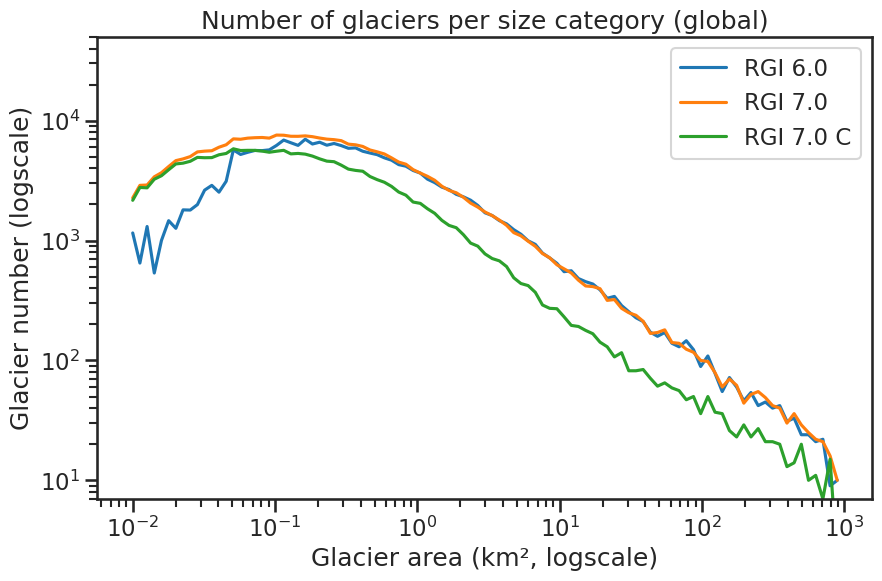

In [78]:
with sns.plotting_context('talk'), sns.axes_style('ticks'):

    bins = np.logspace(-2, 3, 100)

    h7c, b7c = np.histogram(df_rgi7c['area_km2'], bins=bins)
    h7, b7 = np.histogram(rgi7['area_km2'], bins=bins)
    h6, b6 = np.histogram(rgi6['Area'], bins=bins)

    f, ax = plt.subplots(figsize=(10, 6))
    ax.plot(b6[:-1], h6, label='RGI 6.0');
    ax.plot(b7[:-1], h7, label='RGI 7.0');
    ax.plot(b7c[:-1], h7c, label='RGI 7.0 C');
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([7, 5e4])
    plt.legend()
    ax.set_title('Number of glaciers per size category (global)')
    ax.set_xlabel('Glacier area (km², logscale)');
    ax.set_ylabel('Glacier number (logscale)');

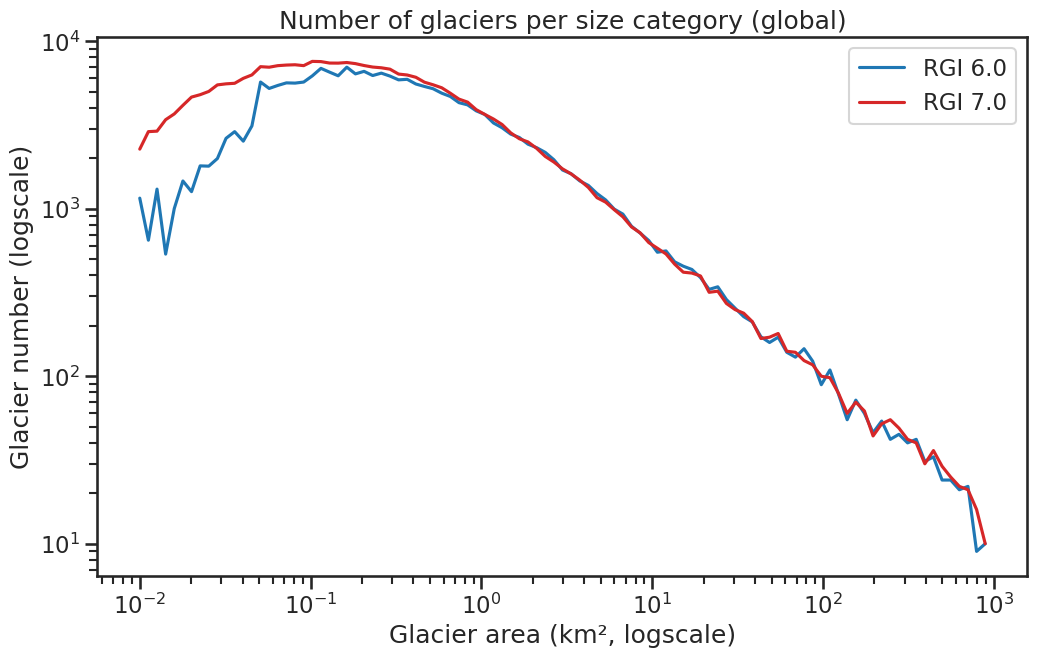

In [81]:
with sns.plotting_context('talk'), sns.axes_style('ticks'):

    bins = np.logspace(-2, 3, 100)

    h7, b7 = np.histogram(rgi7['area_km2'], bins=bins)
    h6, b6 = np.histogram(rgi6['Area'], bins=bins)

    f, ax = plt.subplots(figsize=(12, 7))
    ax.plot(b6[:-1], h6, color='C0', label='RGI 6.0');
    ax.plot(b7[:-1], h7, color='C3', label='RGI 7.0');
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.legend()
    ax.set_title('Number of glaciers per size category (global)')
    ax.set_xlabel('Glacier area (km², logscale)');
    ax.set_ylabel('Glacier number (logscale)');
    plt.savefig(user_guide_dir + '/docs/img/global_stats/global_histogram.png', dpi=100, bbox_inches='tight')

### Global attributes statistics 

In [96]:
rgi7['rgi_id'] = rgi7.index
rgi6['RGIId'] = rgi6.index

#### Terminus 

In [97]:
rdf = pd.DataFrame(index=[0, 1, 2, 3, 9])
rdf.index.name = 'Value'
rdf['Terminus type'] = ['Land-terminating', 'Marine-terminating', 'Lake-terminating', 'Shelf-terminating', 'Not assigned']
rdf['RGI7 (N)'] = rgi7.groupby('term_type').count()['rgi_id']
rdf['RGI6 (N)'] = rgi6.groupby('TermType').count()['RGIId'].reset_index(drop=True)
rdf['RGI7 (Area)'] = rgi7.groupby('term_type')['area_km2'].sum().round(0).astype(int)
rdf['RGI6 (Area)'] = rgi6.groupby('TermType')['Area'].sum().round(0).reset_index(drop=True)
rdf = rdf.replace(np.NaN, 0)
rdf[['RGI7 (N)', 'RGI6 (N)']] = rdf[['RGI7 (N)', 'RGI6 (N)']].astype(int)
rdf[['RGI7 (Area)', 'RGI6 (Area)']] = rdf[['RGI7 (Area)', 'RGI6 (Area)']].astype(int)
rdf.columns = ['Terminus type', 'RGI 7.0 (N)', 'RGI 6.0 (N)', 'RGI 7.0 (Area)', 'RGI 6.0 (Area)']
rdf

Terminus type  RGI 7.0 (N)  RGI 6.0 (N)  RGI 7.0 (Area)  \
Value                                                                 
0        Land-terminating            0       212005               0   
1      Marine-terminating         1561         3075          159302   
2        Lake-terminating            0          298               0   
3       Shelf-terminating            0          169               0   
9            Not assigned       272970            0          547442   

       RGI 6.0 (Area)  
Value                  
0              397096  
1              197514  
2               27172  
3               83958  
9                   0

In [98]:
print(rdf.to_markdown())

|   Value | Terminus type      |   RGI 7.0 (N) |   RGI 6.0 (N) |   RGI 7.0 (Area) |   RGI 6.0 (Area) |
|--------:|:-------------------|--------------:|--------------:|-----------------:|-----------------:|
|       0 | Land-terminating   |             0 |        212005 |                0 |           397096 |
|       1 | Marine-terminating |          1561 |          3075 |           159302 |           197514 |
|       2 | Lake-terminating   |             0 |           298 |                0 |            27172 |
|       3 | Shelf-terminating  |             0 |           169 |                0 |            83958 |
|       9 | Not assigned       |        272970 |             0 |           547442 |                0 |


#### Surging 

In [99]:
rdf = pd.DataFrame(index=[0, 1, 2, 3, 9])
rdf.index.name = 'Value'
rdf['Surging'] = ['No evidence', 'Possible', 'Probable', 'Observed', 'Not assigned']
rdf['RGI7 (N)'] = rgi7.groupby('surge_type').count()['rgi_id']
rdf['RGI6 (N)'] = rgi6.groupby('Surging').count()['RGIId']
rdf['RGI7 (Area)'] = rgi7.groupby('surge_type')['area_km2'].sum().round(0).astype(int)
rdf['RGI6 (Area)'] = rgi6.groupby('Surging')['Area'].sum().round(0).astype(int)
rdf = rdf.replace(np.NaN, 0)
rdf[['RGI7 (N)', 'RGI6 (N)']] = rdf[['RGI7 (N)', 'RGI6 (N)']].astype(int)
rdf[['RGI7 (Area)', 'RGI6 (Area)']] = rdf[['RGI7 (Area)', 'RGI6 (Area)']].astype(int)
rdf.columns = ['Surge type', 'RGI 7.0 (N)', 'RGI 6.0 (N)', 'RGI 7.0 (Area)', 'RGI 6.0 (Area)']
rdf

Surge type  RGI 7.0 (N)  RGI 6.0 (N)  RGI 7.0 (Area)  RGI 6.0 (Area)
Value                                                                        
0       No evidence       271901        42515          566418          127426
1          Possible          630          509           23334           23622
2          Probable          825          383           31254           19376
3          Observed         1175          448           85738           43066
9      Not assigned            0       171692               0          492249

In [100]:
print(rdf.to_markdown())

|   Value | Surge type   |   RGI 7.0 (N) |   RGI 6.0 (N) |   RGI 7.0 (Area) |   RGI 6.0 (Area) |
|--------:|:-------------|--------------:|--------------:|-----------------:|-----------------:|
|       0 | No evidence  |        271901 |         42515 |           566418 |           127426 |
|       1 | Possible     |           630 |           509 |            23334 |            23622 |
|       2 | Probable     |           825 |           383 |            31254 |            19376 |
|       3 | Observed     |          1175 |           448 |            85738 |            43066 |
|       9 | Not assigned |             0 |        171692 |                0 |           492249 |
